# Weak lensing weights to compute the $\Delta\Sigma$ profile

The excess surface mass density profile computed from the data is computed from a weighted average
$$
     \widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l,s = 1} w_{l,s}}
     \sum\limits_{l,s= 1}w_{l,s}\widehat{\Sigma_{{\rm crit}}}(z_s, z_l)\epsilon_+^{l,s}.
$$

where the sum runs over all lens-background source pairs, $\epsilon_+^{l,s}$ is the tangential ellipticity, $\Sigma_{\rm crit}(z_s, z_l)$ is the critical surface density, and where the weights

$$
    w_{l,s} = \frac{\left(\int_{z_l}^{+\infty}\Sigma_{\rm crit}(z_l, z)^{-1}p(z) dz\right)^2}{\sigma^2_{\rm shapenoise} + \sigma^2_{\rm shape\ error}}.
$$
Where $p(z)$ is the photometric redshift ditribution. These weights correspond to the maximum likelihood estimator of $\Delta\Sigma$ (e.g., Shirasaki & Takada 2018).

Identifying background galaxies can be made by considering the individual probability to be in the background of the cluster i.e. 
$$
P(z > z_l) = \int_{z_l}^{+\infty} dz\ p(z) 
$$
to be higher than a given threshold.

In this notebook, we show the `clmm` functionalities developed to compute:
- those weights under a variety of configuration (true redhsifts or photoz, shape noise or not, ideal galaxy shapes or not).
- the background probability $P(z > z_l)$ for each galaxy

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy

import clmm
from clmm import Cosmology
from clmm import GalaxyCluster
from clmm.dataops import compute_galaxy_weights
from clmm.support import mock_data as mock
clmm.__version__

'1.1.0'

In [2]:
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)

In [3]:
cluster_z = 0.4

In [4]:
noisy_data_z = mock.generate_galaxy_catalog(1e14, cluster_z, 4, 
                                                cosmo, 
                                                zsrc = 'chang13', 
                                                delta_so=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min=0.,
                                                zsrc_max=3., 
                                                field_size=10., 
                                                shapenoise=0.5, 
                                                photoz_sigma_unscaled=0.05,
                                                mean_e_err=.1,
                                                ngals=10000)
z_gal = noisy_data_z['ztrue']
z_gal_photoz = noisy_data_z['pzbins']
photoz_pdf_gal = noisy_data_z['pzpdf']
#add redshift dependency on shape measurement error
noisy_data_z['e_err'] = noisy_data_z['e_err']*(1 + 0.4*noisy_data_z['z'])
cl = GalaxyCluster('mock_cluster', 0, 0, .4, noisy_data_z)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/clmm-1.1.0-py3.7.egg/clmm/theory/func_layer.py:499: UserWarning: Some source redshifts are lower than the cluster redshift. kappa = 0 for those galaxies.


## Compute the WL weights

### using the functional interface

In [5]:
w_ls_true = compute_galaxy_weights(
    cluster_z, cosmo,z_source = z_gal, 
    shape_component1 = noisy_data_z['e1'], shape_component2 = noisy_data_z['e2'], 
    shape_component1_err = noisy_data_z['e_err'],
    shape_component2_err = noisy_data_z['e_err'], 
    pzpdf = None, pzbins = None,
    use_shape_noise = False, is_deltasigma = False)

### or as a method of the `GalaxyCluster` object

#### true redshift + no shape error

$$
w_{\rm ls} = \Sigma_{\rm crit}(z_l, z_s)^{-2}
$$

In [6]:
w_ls_true = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = False, use_shape_noise = False, use_shape_error = False, 
    weight_name = 'w_ls_true', cosmo = cosmo, is_deltasigma = True, add = True)

#### photoz + no shape errors

$$
w_{\rm ls} = \left(\int_{z_l}^{+\infty}\Sigma_{\rm crit}(z_l, z)^{-1}p(z) dz\right)^2
$$

In [7]:
w_ls_photoz = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = True, use_shape_noise = False, use_shape_error = False, 
    weight_name = 'w_ls_photoz', cosmo = cosmo, is_deltasigma = True, add = True)

#### true redshift + shape error

$$
w_{\rm ls} = \frac{\Sigma_{\rm crit}(z_l, z_s)^{-2}}{\sigma_{\rm shapenoise}^2 + \sigma^2_{\rm shape\ error}}
$$

In [8]:
w_ls_shape = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = False, use_shape_noise = True, use_shape_error = True, 
    weight_name = 'w_ls_shape', cosmo = cosmo,
    is_deltasigma = True, add = True)

#### photoz + shape error

$$
w_{\rm ls} = \frac{\left(\int_{z_l}^{+\infty}\Sigma_{\rm crit}(z_l, z)^{-1}p(z) dz\right)^2}{\sigma_{\rm shapenoise}^2 + \sigma^2_{\rm shape\ error}}
$$

In [9]:
w_ls_photoz_shape = cl.compute_galaxy_weights(
    z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins', 
    shape_component1 = 'e1', shape_component2 = 'e2', 
    shape_component1_err = 'e_err', shape_component2_err = 'e_err', 
    use_photoz = True, use_shape_noise = True, use_shape_error = True, 
    weight_name = 'w_ls_photoz_shape', cosmo = cosmo,
    is_deltasigma = True, add = True)

The above methods add the new columns in the `cl.galcat` Table with weights and background probabilities per galaxy in each 

In [10]:
print(cl.galcat.colnames)

['ra', 'dec', 'e1', 'e2', 'e_err', 'z', 'ztrue', 'pzbins', 'pzpdf', 'id', 'w_ls_true', 'w_ls_photoz', 'w_ls_shape', 'w_ls_photoz_shape']


Text(0.5, 0, 'true redshift')

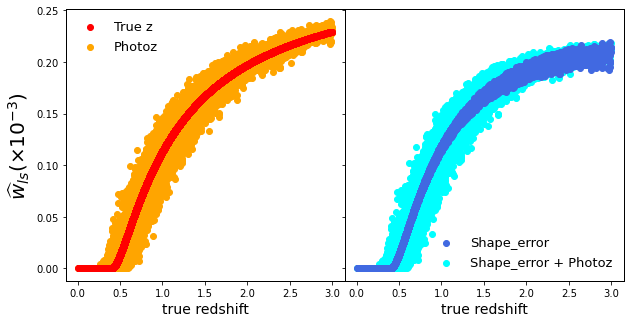

In [11]:
plt.rcParams['axes.linewidth'] = 1
fig, ax = plt.subplots(1,2, figsize = (10,5), sharey = True)
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].tick_params(axis='both', which = 'major', labelsize= 10)
ax[1].tick_params(axis='both', which = 'major', labelsize= 10)
ax[0].scatter(z_gal, 1e3*cl.galcat['w_ls_true']/np.sum(cl.galcat['w_ls_true']), c='r', label = 'True z', zorder = 100)
ax[0].scatter(z_gal, 1e3*cl.galcat['w_ls_photoz']/np.sum(cl.galcat['w_ls_photoz']), c='orange', label = 'Photoz')
ax[1].scatter(z_gal, 1e3*cl.galcat['w_ls_shape']/np.sum(cl.galcat['w_ls_shape']), c='royalblue', label = r'Shape_error', zorder = 100)
ax[1].scatter(z_gal, 1e3*cl.galcat['w_ls_photoz_shape']/np.sum(cl.galcat['w_ls_photoz_shape']), c='cyan', label ='Shape_error + Photoz')
ax[0].legend(frameon = False, fontsize = 13)
ax[1].legend(frameon = False, fontsize = 13)
ax[0].set_ylabel(r'$\widehat{w}_{ls} (\times 10^{-3})$', fontsize = 20)
ax[0].set_xlabel('true redshift', fontsize = 14)
ax[1].set_xlabel('true redshift', fontsize = 14)

The figure above shows the normalized weight per galaxy $\widehat{w}_{ls} = \frac{w_{ls}}{\sum _{s = 1}^N w_{ls}}$.
- The galaxy weights increase with the true galaxy redshift (left panel, red dots), i.e. weights take account that galaxies far from the cluster are more sheared than closer ones.
- Using true redshift (left panel, red dots), weights for foreground galaxies are 0.
- Adding photoz's (left panel, orange dots):
   - weights are scattered around the true redshift weigthts (when photoz's are not biased)
   - foreground galaxies (with true redshift < $z_l$) have non-zero weights
- Adding shape error with redshift dependency $\sigma(z) = \sigma_0(1 + \alpha z)$ (right panel, blus dots), high redshift galaxies with measured shapes have smaller weights than considering true shapes (comparing to left panel, red dots).
- when combining photoz + shape error, both effects can be seen on galaxy weights (right panel, cyan dots).

### Background probability

In [12]:
noisy_data_z_2 = mock.generate_galaxy_catalog(1e14, cluster_z, 4, 
                                                cosmo, 
                                                zsrc = 'chang13', 
                                                #Delta_SO=200, 
                                                massdef='critical',
                                                halo_profile_model='nfw', 
                                                zsrc_min=0.,
                                                zsrc_max=3., 
                                                field_size=10., 
                                                shapenoise=0.5, 
                                                photoz_sigma_unscaled=0.03, 
                                                mean_e_err=.1,
                                                ngals=10000)
z_gal_2 = noisy_data_z_2['ztrue']
z_gal_photoz_2 = noisy_data_z_2['pzbins']
photoz_pdf_gal_2 = noisy_data_z_2['pzpdf']
#add redshift dependency on shape measurement error
noisy_data_z_2['e_err'] = noisy_data_z_2['e_err']*(1 + 0.4*noisy_data_z_2['z'])
cl_2 = clmm.GalaxyCluster('mock_cluster', 0, 0, cluster_z, noisy_data_z_2)

The probability for a galaxy with photometric redshift of being in the background of the cluster is given by
$$
P(z > z_l) = \int_{z_l}^{+\infty} dz\ p(z) 
$$

In [13]:
p_background_true = cl.compute_background_probability(z_source='ztrue', pzpdf=None, pzbins=None,
                                       use_photoz=False, p_background_name='p_background_true',
                                       add=True)

In [14]:
p_background_photoz_1 = cl.compute_background_probability(z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins',
                                       use_photoz=True, p_background_name='p_background_photoz_1',
                                       add=True)

In [15]:
p_background_photoz_2 = cl_2.compute_background_probability(z_source='ztrue', pzpdf='pzpdf', pzbins='pzbins',
                                       use_photoz=True, p_background_name='p_background_photoz_2',
                                       add=True)

Text(0.5, 0, 'true redshift')

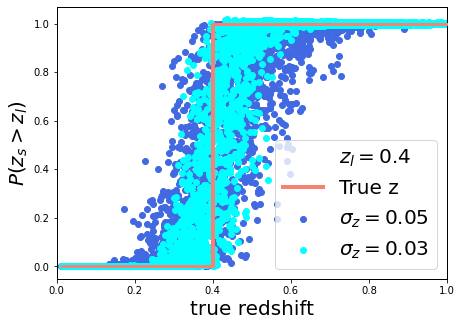

In [16]:
plt.rcParams['axes.linewidth'] = 1
plt.figure( figsize = (7,5))
plt.tick_params(axis='both', which = 'major', labelsize= 10)
plt.plot([],[],' ', label = f'$z_l = {cluster_z}$', )
plt.scatter(z_gal, p_background_photoz_1, c='royalblue', label = r'$\sigma_z = 0.05$')
plt.scatter(z_gal_2, p_background_photoz_2, c='cyan', label = r'$\sigma_z = 0.03$')
plt.vlines(cluster_z, 0,1,color='salmon', linewidth = 4, zorder = 100)
plt.scatter(z_gal, p_background_true, c='salmon', s = 3, zorder = 110)
plt.plot([],[], label = 'True z', linewidth = 4, c = 'salmon')
plt.xlim(0., 1)
plt.legend(frameon = True, fontsize = 20)
plt.ylabel(r'$P(z_s > z_l)$', fontsize = 20)
plt.xlabel('true redshift', fontsize = 20)

The figure above shows the background probability $P(z > z_l)$ for each galaxy.
- When using true redshift, the background probability is a Heavyside function centered on $z_s$ (orange curve), i.e. $p(z) = \delta^D(z-z_s)$.
- when using photometric redshift (cyan and blue dots), galaxies on the foreground of the cluster have non-zero probability to be in the background. Idem, for close galaxies in the background, the probability in being in the foreground is non-zero.